# Retrieve HSP CCT Mouse Sequences

### Ayush Noori

Import required libraries.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Directory management
from pathlib import Path
import os
import shutil

# Get sequence data
from getSequence import getseq

# Get JSON data
import json

# Get current directory
cwd = Path(os.getcwd())
save_dir = cwd.parents[1] / 'Data' / 'AF2_sequences' / 'HSP_CCT_mouse'

# !pip install pychimera

Get list of UniProt IDs.

In [2]:
# Dictionary of UniProt IDs
Gfap_id = 'P03995' # mouse version
# Cct7, Cct8, Hspa4, Hspd1, Hsp90b1, Psmb1, Psmb6, Uba1, Lgals1, Lgals3, Rab1b, Rab7a, Rab10, G3bp1

experimental_conditions = {
    'Gfap-Cct7': (Gfap_id, 'P80313'),
    'Gfap-Cct8': (Gfap_id, 'P42932'),
    'Gfap-Hspa4': (Gfap_id, 'Q61316'),
    'Gfap-Hspd1': (Gfap_id, 'P63038'),
    'Gfap-Hsp90b1': (Gfap_id, 'P08113'),
    'Gfap-Psmb1': (Gfap_id, 'O09061'),
    'Gfap-Psmb6': (Gfap_id, 'Q60692'),
    'Gfap-Uba1': (Gfap_id, 'Q02053'),
    'Gfap-Lgals1': (Gfap_id, 'P16045'),
    'Gfap-Lgals3': (Gfap_id, 'P16110'),
    'Gfap-Rab1b': (Gfap_id, 'Q9D1G1'),
    'Gfap-Rab7a': (Gfap_id, 'P51150'),
    'Gfap-Rab10': (Gfap_id, 'P61027'),
    'Gfap-G3bp1': (Gfap_id, 'P97855'),
    'Gfap-Vdac1': (Gfap_id, 'Q60932'),
}

# Label experimental, positive, and negative controls
experimental_conditions = {k: (v, 'exp') for k, v in experimental_conditions.items()}

# Combine all dictionaries
# af2_experiments = {**experimental_conditions, **positive_controls, **negative_controls}
af2_experiments = {**experimental_conditions}

Retrieve sequences and write to file.

In [3]:
# Iterate over controls
for comparison, (uniprot_ids, label) in af2_experiments.items():
    
    # Save sequence
    with open(save_dir / f'{comparison}-{label}.fasta', 'w') as f:

        # Iterate over UniProt IDs
        for uniprot_id in uniprot_ids:

            # Get sequence
            seq = getseq(uniprot_id, uniprot_id=True)

            # Write header to file
            f.write(f'>{seq[0]}\n')

            # Divide sequence into chunks of 60 characters
            for i in range(0, len(seq[1]), 60):
                f.write(f'{seq[1][i:i+60]}\n')

# Visualize PDB Structures

In [4]:
# Define directories
results_dir = cwd.parents[1] / 'Results' / 'AF2_multimer' / 'HSP_CCT_mouse'
plot_dir = cwd.parents[1] / 'Results' / 'AF2_multimer' / 'plots' / 'HSP_CCT_mouse'
pdb_dir = plot_dir / 'PDBs'

# Get AF2 predictions
af2_preds = {x.name: {'path': x} for x in results_dir.iterdir() if x.is_dir()}
af2_preds.pop('raw_output', None)
af2_preds = dict(sorted(af2_preds.items()))

# For each experiment
for key, dir in af2_preds.items():

    # Get comparison name
    comparison = key.split('-exp')[0].replace('-', '_')
    af2_preds[key]['comparison'] = comparison
    print("Analyzing", comparison)

    # Get directory
    dir = dir['path']

    # Read in key+'_ranking_debug.json'
    with open(dir / f'{key}_ranking_debug.json') as f:
        ranking_debug = json.load(f)

    # Get best model
    best_model = ranking_debug['order'][0]
    best_model_score = ranking_debug['iptm+ptm'][best_model]

    # Print best model
    print(f"Best model: {best_model}")
    print(f"iPTM + PTM score {best_model_score:.6f}")
    af2_preds[key]['best_model'] = best_model
    af2_preds[key]['best_model_score'] = best_model_score

    # Add PDB file path to dictionary
    pdb_file_path = dir / f'{key}_unrelaxed_{best_model}.pdb'
    af2_preds[key]['pdb'] = pdb_file_path

    # Copy best_model PDB file to PDB directory
    shutil.copy(pdb_file_path, pdb_dir / f'{comparison}.pdb')

Analyzing Gfap_Cct7
Best model: model_5_multimer_v3_pred_0
iPTM + PTM score 0.221399
Analyzing Gfap_Cct8
Best model: model_3_multimer_v3_pred_0
iPTM + PTM score 0.213853
Analyzing Gfap_G3bp1
Best model: model_3_multimer_v3_pred_0
iPTM + PTM score 0.258157
Analyzing Gfap_Hsp90b1
Best model: model_1_multimer_v3_pred_0
iPTM + PTM score 0.268291
Analyzing Gfap_Hspa4
Best model: model_3_multimer_v3_pred_0
iPTM + PTM score 0.265020
Analyzing Gfap_Hspd1
Best model: model_3_multimer_v3_pred_0
iPTM + PTM score 0.273771
Analyzing Gfap_Lgals1
Best model: model_5_multimer_v3_pred_0
iPTM + PTM score 0.152135
Analyzing Gfap_Lgals3
Best model: model_4_multimer_v3_pred_0
iPTM + PTM score 0.188107
Analyzing Gfap_Psmb1
Best model: model_4_multimer_v3_pred_0
iPTM + PTM score 0.165135
Analyzing Gfap_Psmb6
Best model: model_5_multimer_v3_pred_0
iPTM + PTM score 0.540619
Analyzing Gfap_Rab10
Best model: model_1_multimer_v3_pred_0
iPTM + PTM score 0.228267
Analyzing Gfap_Rab1b
Best model: model_3_multimer_v3

## Generate Chimera Commands

In [80]:
# For each experiment, alphabetically
for key, val in af2_preds.items():

    # Get comparison name
    comparison = val['comparison']
    # print("Analyzing", comparison)

    print('open ', '"', str(pdb_dir / f'{comparison}.pdb'), '";', sep='')
    print("color #1/B red;")
    print("color #1/C gray;")
    print(f'save "{plot_dir}/images/{comparison}.png" transparentBackground true pixelSize 0.05 supersample 4;')
    print("movie record;")
    print("turn y 2 180;")
    print("wait 180;")
    print(f'movie encode "{plot_dir}/movies/{comparison}.mp4";')
    print("close #1;")
    print("")

open "/Users/an583/HMS Dropbox/Ayush Noori/GFAP projects 2/GFAP AAV Tau Mice/ayush-GFAP-overexpression/Results/AF2_multimer/plots/HSP_CCT_mouse/PDBs/Gfap_Cct7.pdb";
color #1/B red;
color #1/C gray;
save "/Users/an583/HMS Dropbox/Ayush Noori/GFAP projects 2/GFAP AAV Tau Mice/ayush-GFAP-overexpression/Results/AF2_multimer/plots/HSP_CCT_mouse/images/Gfap_Cct7.png" transparentBackground true pixelSize 0.05 supersample 4;
movie record;
turn y 2 180;
wait 180;
movie encode "/Users/an583/HMS Dropbox/Ayush Noori/GFAP projects 2/GFAP AAV Tau Mice/ayush-GFAP-overexpression/Results/AF2_multimer/plots/HSP_CCT_mouse/movies/Gfap_Cct7.mp4";
close #1;

open "/Users/an583/HMS Dropbox/Ayush Noori/GFAP projects 2/GFAP AAV Tau Mice/ayush-GFAP-overexpression/Results/AF2_multimer/plots/HSP_CCT_mouse/PDBs/Gfap_Cct8.pdb";
color #1/B red;
color #1/C gray;
save "/Users/an583/HMS Dropbox/Ayush Noori/GFAP projects 2/GFAP AAV Tau Mice/ayush-GFAP-overexpression/Results/AF2_multimer/plots/HSP_CCT_mouse/images/Gfap_C

# Generate Sequence Heatmaps

In [6]:
# From https://medium.com/@jgbrasier/working-with-pdb-files-in-python-7b538ee1b5e4

import pandas as pd
from biopandas.pdb import PandasPdb
from prody import parsePDBHeader
from typing import Optional

def read_pdb_to_dataframe(
    pdb_path: Optional[str] = None,
    model_index: int = 1,
    parse_header: bool = True,
    ) -> pd.DataFrame:
    """
    Read a PDB file, and return a Pandas DataFrame containing the atomic coordinates and metadata.

    Args:
        pdb_path (str, optional): Path to a local PDB file to read. Defaults to None.
        model_index (int, optional): Index of the model to extract from the PDB file, in case
            it contains multiple models. Defaults to 1.
        parse_header (bool, optional): Whether to parse the PDB header and extract metadata.
            Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the atomic coordinates and metadata, with one row
            per atom
    """
    atomic_df = PandasPdb().read_pdb(pdb_path)
    if parse_header:
        header = parsePDBHeader(pdb_path)
    else:
        header = None
    atomic_df = atomic_df.get_model(model_index)
    if len(atomic_df.df["ATOM"]) == 0:
        raise ValueError(f"No model found for index: {model_index}")

    return pd.concat([atomic_df.df["ATOM"], atomic_df.df["HETATM"]]), header

In [8]:
from scipy.spatial.distance import cdist
from tqdm import tqdm
# TO MEASURE DISTANCES IN CHIMERA
# distance #1/B:1@CA  #1/C:1@CA
# #1/B:[RESIDUE NUMBER]@[ATOM NAME]
# See https://www.cgl.ucsf.edu/chimerax/docs/user/commands/atomspec.html

# Define method variable to be "min" or "centroid"
DIST_METHOD = "min"

# For each experiment
for key, val in af2_preds.items():

    # Get PDB path
    comparison = val['comparison']
    pdb_path = val['pdb']

    # # Open PDB file
    # parser = PDBParser()
    # structure = parser.get_structure(comparison, pdb_path)
    df, df_header = read_pdb_to_dataframe(pdb_path)

    # Subset by chain ID
    coord_cols = ['residue_name', 'residue_number', 'x_coord', 'y_coord', 'z_coord']
    gfap_df = df[df["chain_id"] == "B"][coord_cols].reset_index(drop=True)
    interactor_df = df[df["chain_id"] == "C"][coord_cols].reset_index(drop=True)

    if DIST_METHOD == "centroid":

        # Group by residue number and average coordinates to get centroid of each residue
        gfap_coords = gfap_df.groupby(["residue_number", "residue_name"], as_index=False).mean()
        interactor_coords = interactor_df.groupby(["residue_number", "residue_name"], as_index=False).mean()

        # Compute pairwise distance between GFAP and interactor residues
        # Extract coordinate arrays
        gfap_points = gfap_coords[['x_coord', 'y_coord', 'z_coord']].values
        interactor_points = interactor_coords[['x_coord', 'y_coord', 'z_coord']].values

        # Compute pairwise distance matrix (rows: GFAP residues, columns: Interactor residues)
        dist_matrix = cdist(gfap_points, interactor_points, metric='euclidean')

        # Create residue index
        gfap_index = gfap_coords[['residue_number', 'residue_name']].apply(lambda x: f"{x['residue_name']}{x['residue_number']}", axis=1).values
        interactor_index = interactor_coords[['residue_number', 'residue_name']].apply(lambda x: f"{x['residue_name']}{x['residue_number']}", axis=1).values

    elif DIST_METHOD == "min":

        # Create empty numpy matrix to store distances
        gfap_res = gfap_df[['residue_number', 'residue_name']].drop_duplicates().reset_index(drop=True)
        interactor_res = interactor_df[['residue_number', 'residue_name']].drop_duplicates().reset_index(drop=True)
        dist_matrix = np.zeros((len(gfap_res), len(interactor_res)))

        # Create residue index
        gfap_index = gfap_res.apply(lambda x: f"{x['residue_name']}{x['residue_number']}", axis=1).values
        interactor_index = interactor_res.apply(lambda x: f"{x['residue_name']}{x['residue_number']}", axis=1).values

        # Set up tqdm progress bars
        outer_pbar = tqdm(total=len(gfap_res), desc="GFAP residues")
        # inner_pbar = tqdm(total=len(interactor_res), desc="Interactor residues")

        # Iterate over GFAP residues
        for i, gfap_i in gfap_res.iterrows():
            for j, interactor_j in interactor_res.iterrows():

                # Get residue number and name
                gfap_num_i = gfap_i['residue_number']
                gfap_name_i = gfap_i['residue_name']
                interactor_num_j = interactor_j['residue_number']
                interactor_name_j = interactor_j['residue_name']

                # Get GFAP and interactor coordinates
                gfap_coords = gfap_df[gfap_df['residue_number'] == gfap_num_i][['x_coord', 'y_coord', 'z_coord']].values
                interactor_coords = interactor_df[interactor_df['residue_number'] == interactor_num_j][['x_coord', 'y_coord', 'z_coord']].values

                # Compute pairwise distance between GFAP and interactor residues
                atom_dist_matrix = cdist(gfap_coords, interactor_coords, metric='euclidean')

                # Take minimum distance
                dist_matrix[i, j] = atom_dist_matrix.min()

                # # Update inner progress bar
                # inner_pbar.update(1)
                # inner_pbar.refresh()
            
            # Update outer progress bar
            outer_pbar.update(1)
            outer_pbar.refresh()
    
    else:
        raise ValueError(f"Invalid distance method: {DIST_METHOD}")
    
    dist_df = pd.DataFrame(dist_matrix, 
                        index=gfap_index, 
                        columns=interactor_index)

    # Average or max across interactor residues
    avg_dist = dist_df.mean(axis=1)
    min_dist = dist_df.min(axis=1)
    max_dist = dist_df.max(axis=1)

    # Save to dictionary
    af2_preds[key]['dist_matrix'] = dist_df
    af2_preds[key]['avg_dist'] = avg_dist
    af2_preds[key]['min_dist'] = min_dist
    af2_preds[key]['max_dist'] = max_dist

GFAP residues: 100%|██████████| 430/430 [04:09<00:00,  1.73it/s]

Create heatmap of sequence distance.

In [67]:
# Define aggregation method
AGG_METHOD = 'min'

avg_dists = {v['comparison'].split('_')[1]: v['avg_dist'] for k, v in af2_preds.items()}
avg_dists = pd.DataFrame(avg_dists)

min_dists = {v['comparison'].split('_')[1]: v['min_dist'] for k, v in af2_preds.items()}
min_dists = pd.DataFrame(min_dists)

max_dists = {v['comparison'].split('_')[1]: v['max_dist'] for k, v in af2_preds.items()}
max_dists = pd.DataFrame(max_dists)

agg_dists = {
    'avg': avg_dists,
    'min': min_dists,
    'max': max_dists
}
agg_dists_labels = {
    'avg': 'Average',
    'min': 'Minimum',
    'max': 'Maximum'
}

In [68]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Perform hierarchical clustering on columns (interactor proteins)
linkage_matrix = linkage(agg_dists[AGG_METHOD].T, method='ward') 
ordered_indices = leaves_list(linkage_matrix)
agg_dist_mtx = agg_dists[AGG_METHOD].iloc[:, ordered_indices] # ordered_indices[::-1]

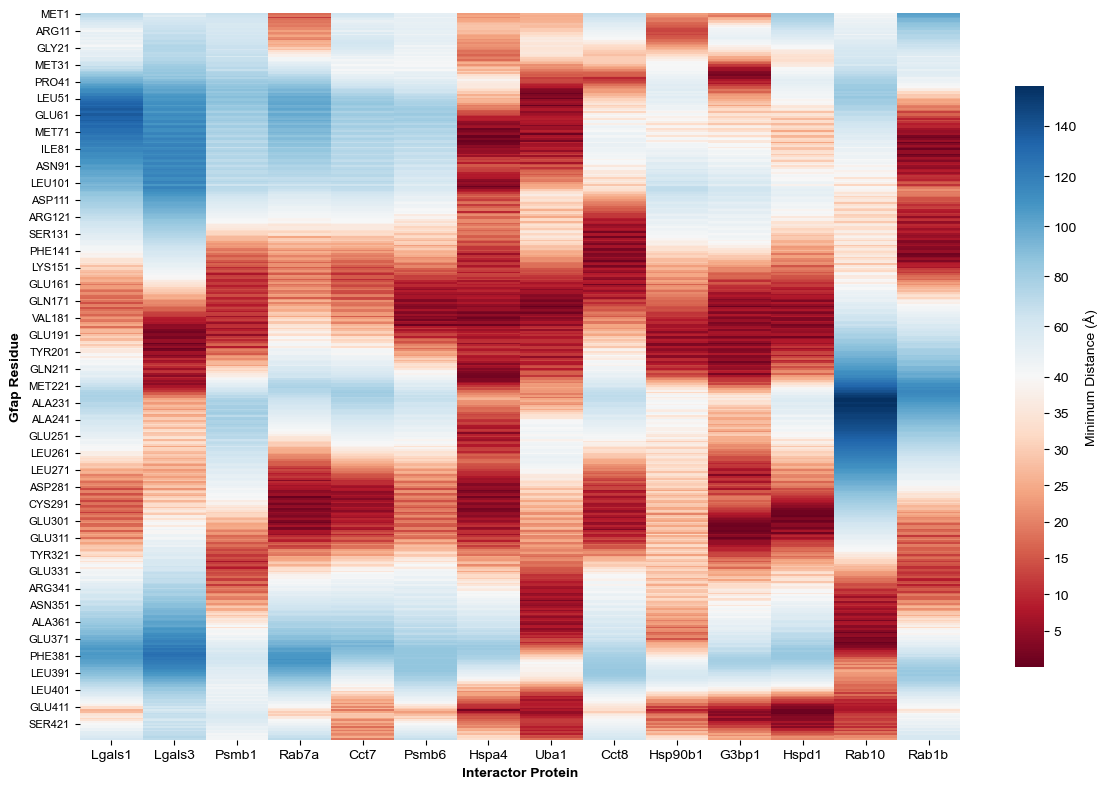

In [69]:
import seaborn as sns
import matplotlib.colors as mcolors

# Set font to Arial for all text
plt.rc('font', family='Arial')

# Create a normalized color map with the custom midpoint
midpoint_value = 40 if AGG_METHOD == 'min' else 100
# vmin = agg_dist_mtx.min().min()
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=midpoint_value, vmax=agg_dist_mtx.max().max())

# Create ticks with interval of 5 from 0 to midpoint and interval of 20 from midpoint to max
cb_ticks = np.concatenate([
    np.arange(5, midpoint_value, 5),
    np.arange(midpoint_value, agg_dist_mtx.max().max() + 1, 20)
])
cb_ticks = cb_ticks if AGG_METHOD == 'min' else None

# Create a heatmap for avg_dists
plt.figure(figsize=(12, 8))

sns.heatmap(
    agg_dist_mtx, 
    cmap='RdBu',  # Red for low values, blue for high values
    annot=False, 
    # linewidths=1.5, 
    # linecolor='black',  # Add black lines around cells
    cbar_kws={"shrink": 0.8, "label": agg_dists_labels[AGG_METHOD] + " Distance (Å)", "ticks": cb_ticks}, 
    yticklabels=True, 
    xticklabels=True,
    norm=norm
)

# plt.title("gfap", fontfamily='Arial')
plt.xlabel("Interactor Protein", fontfamily='Arial', fontweight='bold')
plt.ylabel("Gfap Residue", fontfamily='Arial', fontweight='bold')

# # Make x-axis and y-axis labels smaller
# plt.xticks(fontsize=8)  
# plt.yticks(fontsize=8)  

# Label every 20th residue on the y-axis
num_residues = agg_dist_mtx.shape[0]
tick_positions = np.arange(0, num_residues, 10)
tick_labels = agg_dist_mtx.index[tick_positions]
plt.yticks(tick_positions + 0.5, tick_labels, fontsize=8)  # +0.5 to center ticks in cells
plt.tight_layout()

# Save plot
plt.savefig(plot_dir / f'AF2_mouse_{AGG_METHOD}_dists.pdf', bbox_inches='tight')
plt.savefig(plot_dir / f'AF2_mouse_{AGG_METHOD}_dists.png', dpi=600, bbox_inches='tight')

plt.show()

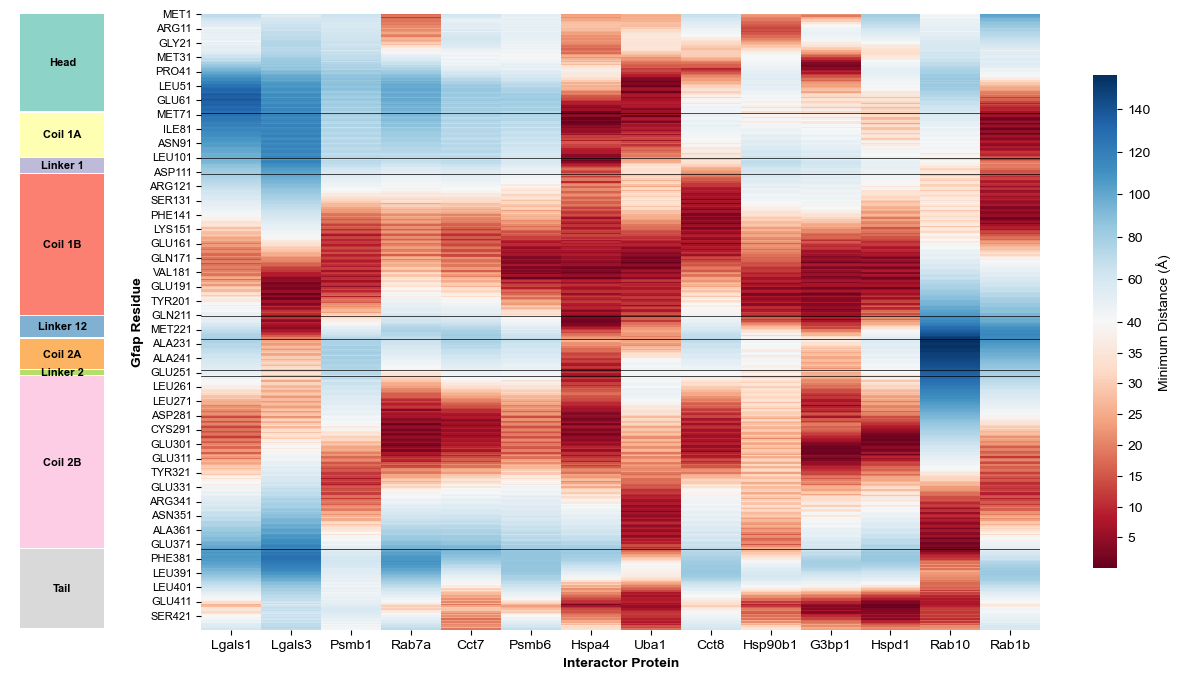

In [70]:
# Example annotation data (Region/Domain: start-end, label)
# From https://www.uniprot.org/uniprotkb/P03995/entry#family_and_domains
annotations = [
    ("Region", 1, 69, "Head"),
    ("Region", 70, 101, "Coil 1A"),
    ("Region", 102, 112, "Linker 1"),
    ("Region", 113, 211, "Coil 1B"),
    ("Region", 212, 227, "Linker 12"),
    ("Region", 228, 249, "Coil 2A"),
    ("Region", 250, 253, "Linker 2"),
    ("Region", 254, 374, "Coil 2B"),
    ("Region", 375, 430, "Tail")
]

# Set font to Arial
plt.rc('font', family='Arial')

# Create main figure and main axis for the heatmap
fig = plt.figure(figsize=(16, 8))

# Increase spacing by making the annotation column wider
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[0.1, 1], wspace=0.15)

# Left axis for annotations
ax_annot = fig.add_subplot(gs[0,0])
# Right axis for heatmap
ax = fig.add_subplot(gs[0,1])

sns.heatmap(
    agg_dist_mtx, 
    cmap='RdBu',  # Red for low values, blue for high values
    annot=False, 
    linewidths=0, 
    cbar_kws={"shrink": 0.8, "label": agg_dists_labels[AGG_METHOD] + " Distance (Å)", "ticks": cb_ticks}, 
    yticklabels=True, 
    xticklabels=True,
    norm=norm,
    ax=ax
)

# Label axes
ax.set_xlabel("Interactor Protein", fontfamily='Arial', fontweight='bold')
ax.set_ylabel("Gfap Residue", fontfamily='Arial', fontweight='bold')

# Label every 20th residue on the y-axis
num_residues = agg_dist_mtx.shape[0]
tick_positions = np.arange(0, num_residues, 10)
tick_labels = agg_dist_mtx.index[tick_positions]
ax.set_yticks(tick_positions + 0.5)
ax.set_yticklabels(tick_labels, fontsize=8)

# Remove x-axis tick labels if desired (not required here)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)

# Now configure the annotation axis
# We want this axis to share the y-range with the heatmap
ax_annot.set_ylim(ax.get_ylim())  # match vertical limits
ax_annot.set_xlim(0, 1)          # a narrow axis from 0 to 1
ax_annot.axis('off')             # no visible axis lines or ticks

# Configure the annotation axis
ax_annot.set_ylim(ax.get_ylim())
ax_annot.set_xlim(0, 1)
ax_annot.axis('off')

# Generate a color palette for all annotations
colors = sns.color_palette("Set3", n_colors=len(annotations))

for i, (atype, start, end, label) in enumerate(annotations):
    # Convert residue numbers (1-based) to 0-based indexing
    start_idx = start - 1
    end_idx = end - 1
    
    color = colors[i]
    
    # Draw a vertical bar for the annotation
    # Using a slightly narrower width (0.8) to avoid touching the heatmap
    ax_annot.axhspan(start_idx, end_idx, xmin=0.1, xmax=0.9, color=color, lw=0)
    
    # Add text label, rotated 90 degrees and centered
    y_mid = (start_idx + end_idx) / 2
    ax_annot.text(
        0.5, y_mid, 
        label, 
        va='center', ha='center', 
        rotation=0, 
        fontsize=8, fontfamily='Arial', 
        fontweight='bold'
    )

# Draw horizontal lines at region boundaries
for _, start, end, _ in annotations:
    # Draw a line at the bottom boundary of each region
    ax.axhline(end, color='black', linewidth=0.5)
# ax.axhline(0, color='black', linewidth=0.5)
# ax.axhline(num_residues, color='black', linewidth=0.5)

# Save plot
plt.savefig(plot_dir / f'AF2_mouse_{AGG_METHOD}_dists_labeled.pdf', bbox_inches='tight')
plt.savefig(plot_dir / f'AF2_mouse_{AGG_METHOD}_dists_labeled.png', dpi=600, bbox_inches='tight')

plt.show()